In [2]:
from IPython.display import HTML
from IPython.display import Image

NOTE: The output here is copied over from the Kaggle kernel, I have copied the raw code, which can be accessed as instructed below, but will not work in this notebook.

In [10]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# TwoSigma Kaggle - EDA

There are two datasets - market data and news data. I am analysing them separately.

# Market Data

The dataset contains stock prices for many companies over a decade! We can see long-term trends, appearing and declining companies.
I am taking 10 random assets and plot them.

print(f'{market_train_df.shape[0]} samples and {market_train_df.shape[1]} features in the training market dataset.')

In [ ]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

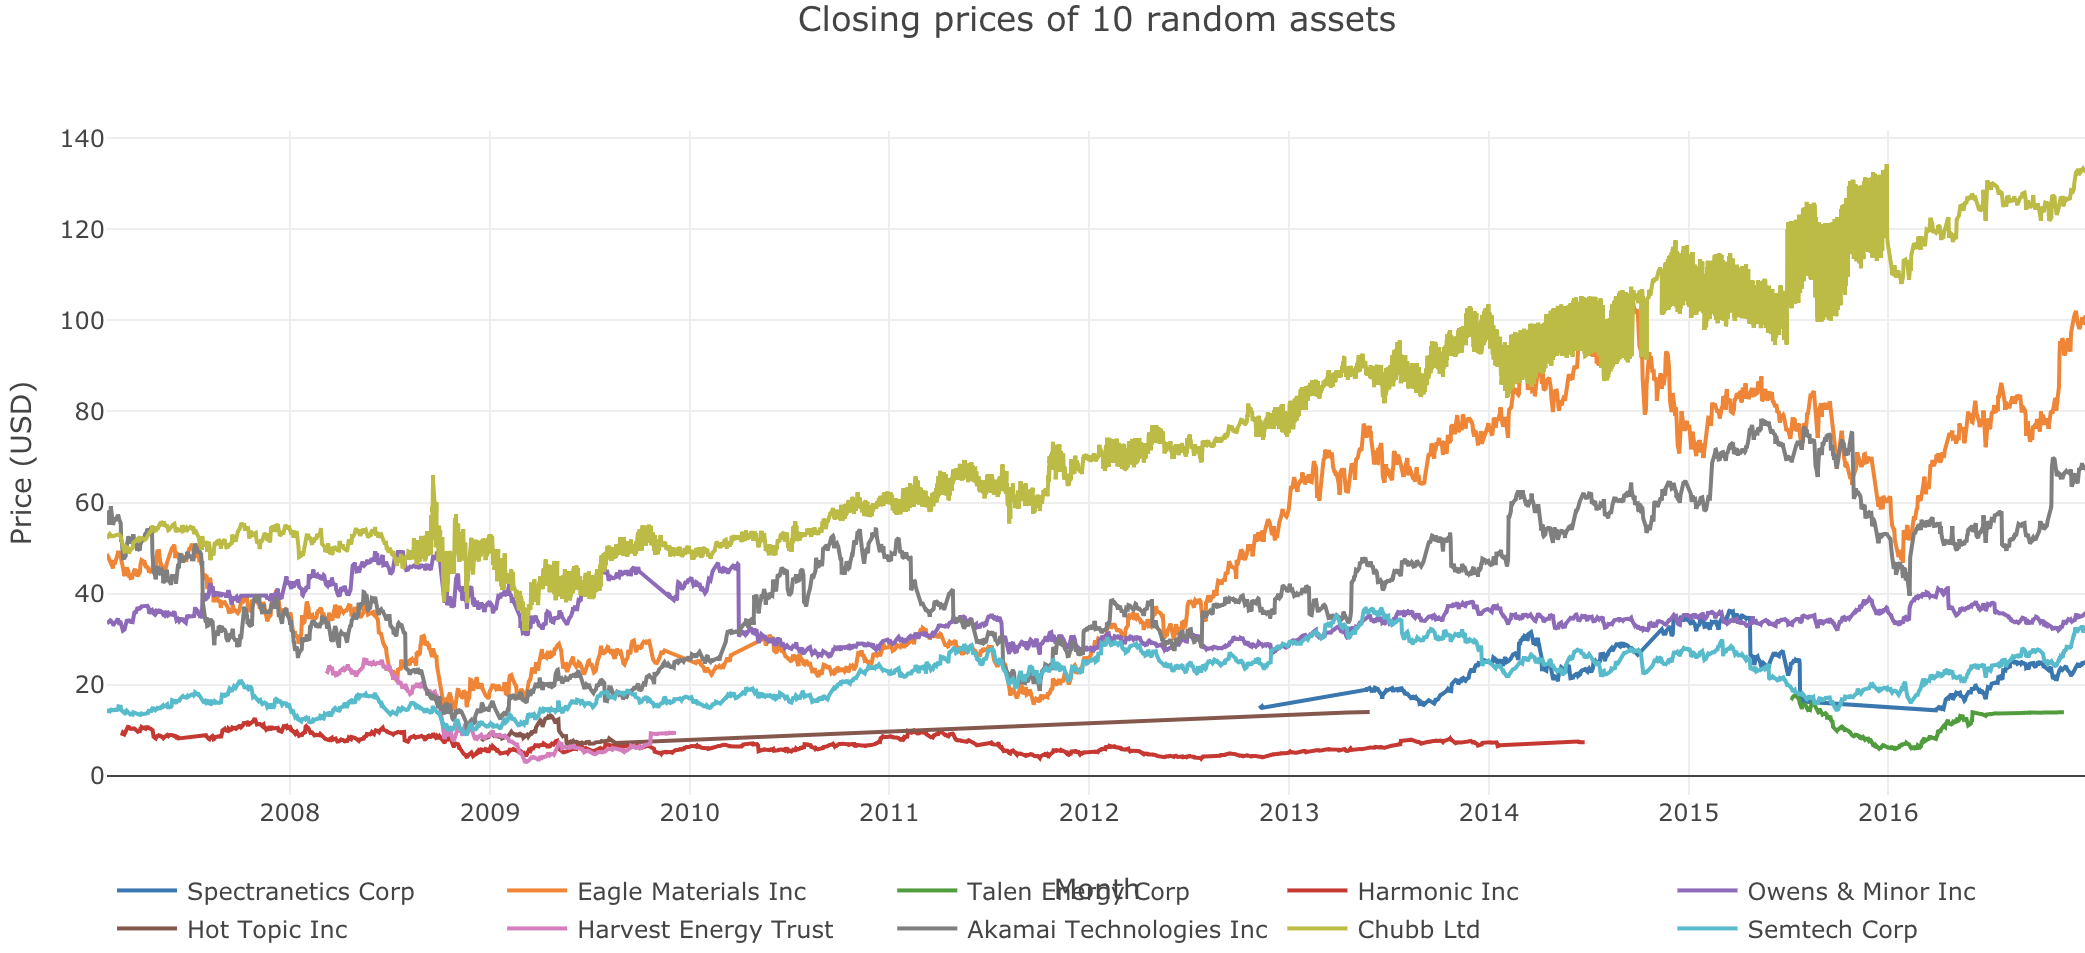

In [19]:
Image(filename='Images/rnd_stocks.png') 

I plot data for all periods because I'd like to show long-term trends.
Assets are sampled randomly, but you should see that some companies' stocks started trading later, some dissappeared. Disappearence could be due to bankruptcy, acquisition or other reasons.

Looking into general trends in prices.

In [ ]:
data = []
#market_train_df['close'] = market_train_df['close'] / 20
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

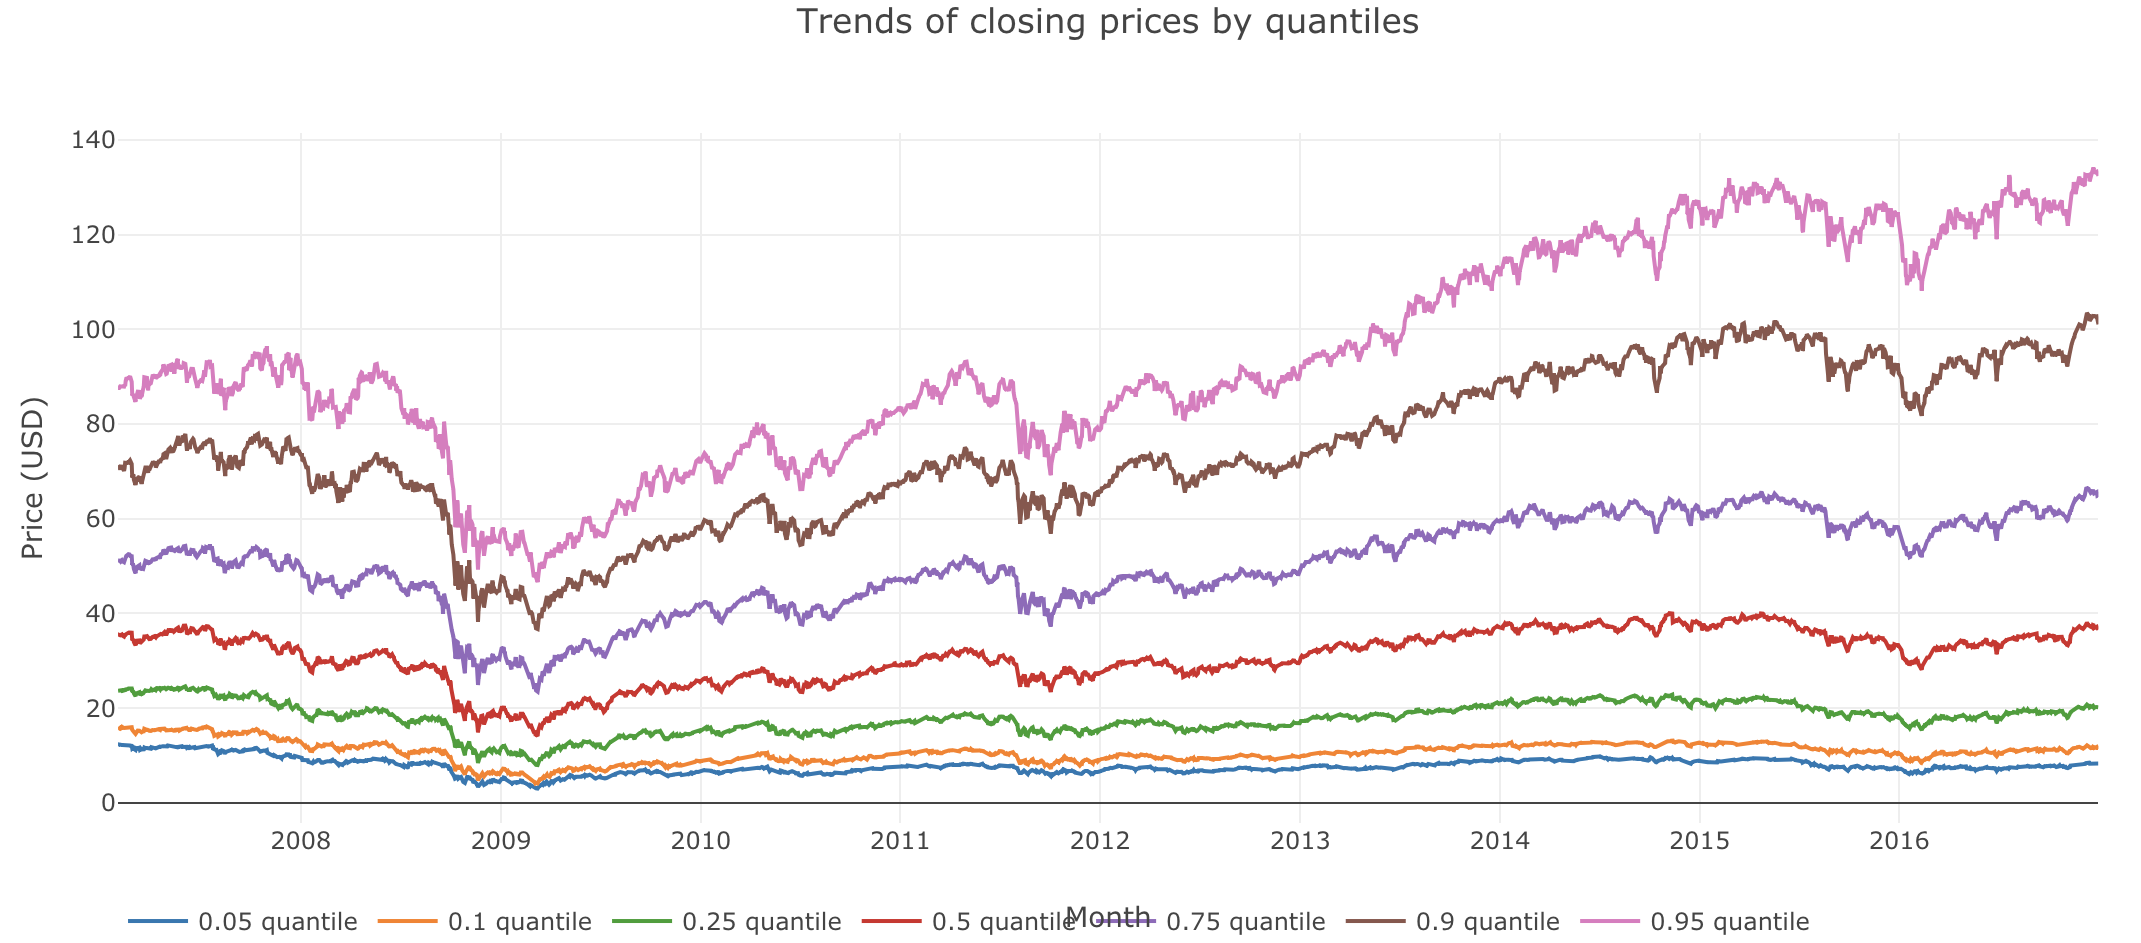

In [20]:
Image(filename='Images/trends_close.png') 

I have shown 4 events when there were serious stock price drops on the market.
You could also notice that higher quantile prices have increased with time and lower quantile prices decreased.
Maybe the gap between poor and rich increases on the other hand maybe more "little" companies are ready to go to market and prices of their shares isn't very high. Now I will look into the price drops.

In [ ]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

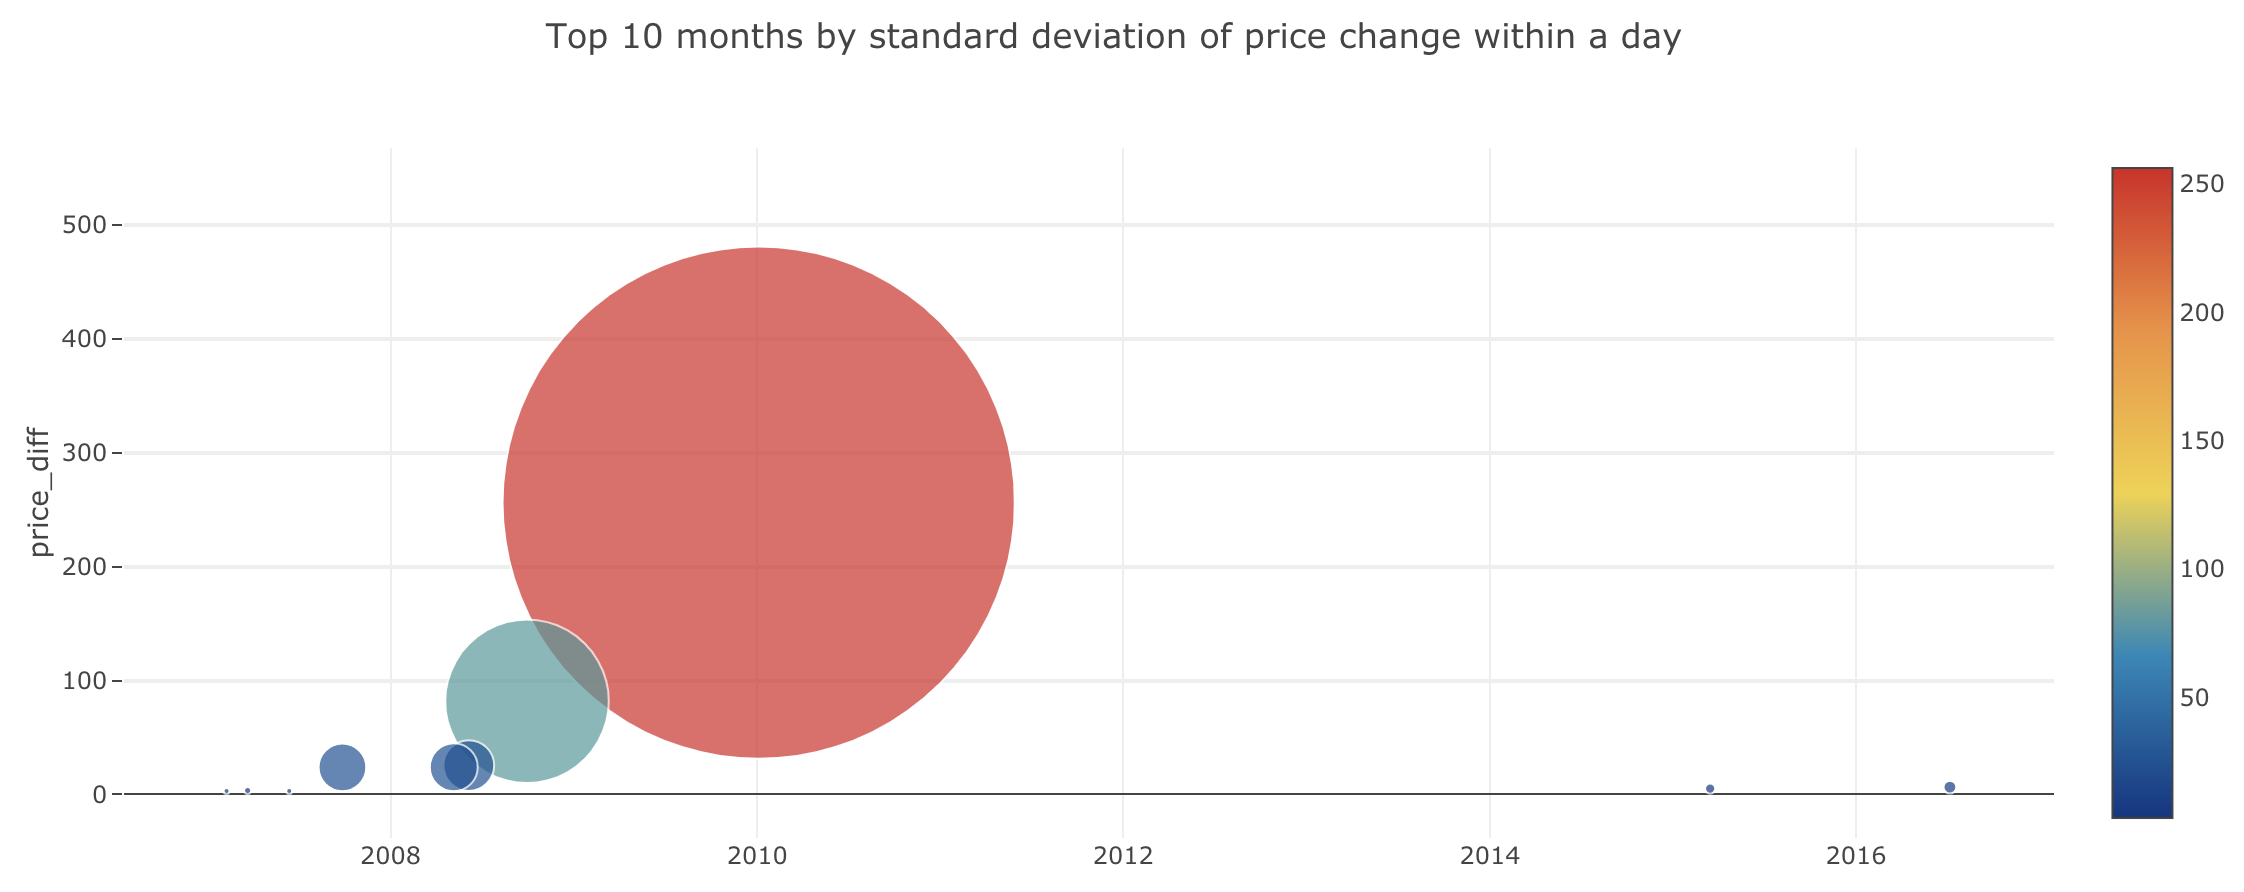

In [21]:
Image(filename='Images/top10_months.png') 

We can see big fluctuations during the crush in 2010. But this doesn't look right as the crush was in 2007/2008.

Sorting the data by the difference between open and close.

In [ ]:
market_train_df.sort_values('price_diff')[:10]

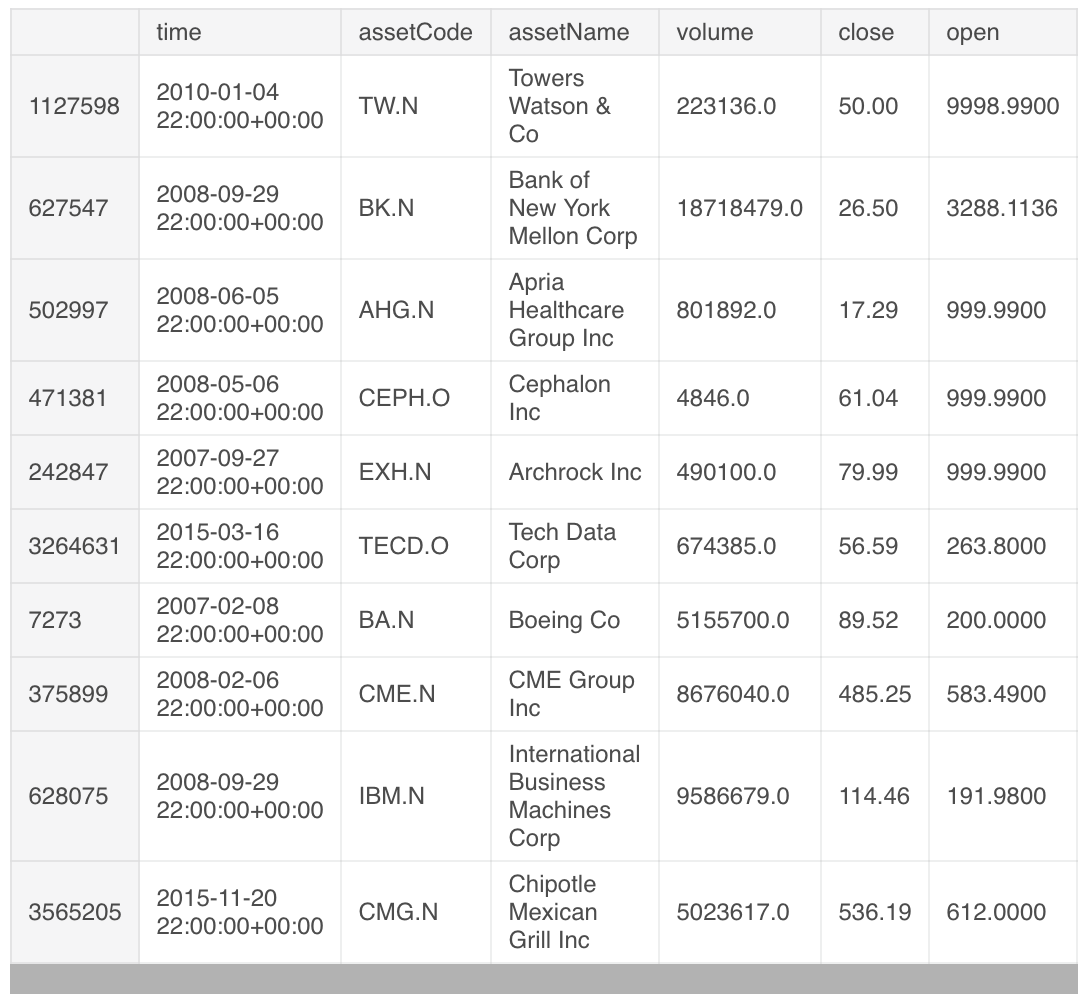

In [22]:
Image(filename='Images/top_diff.png')

So price of "Towers Watson & Co" shares was almost 10k. While checking in the stock exchange data, this was not the case. This is an error. After checking for other errors, all inputs as 999 at the close are errors. But having 4 millions data this should not be a problem.

In [ ]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

In 1211 lines price increased by 20% or more.
In 778 lines price decreased by 20% or more.

In [ ]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 38 lines price increased by 100% or more.
In 16 lines price decreased by 100% or more.

For a quick fix I'll replace outliers in these lines with mean open or close price of this company.

In [ ]:
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

Now looking at the graph again. The prices look more reasonable.

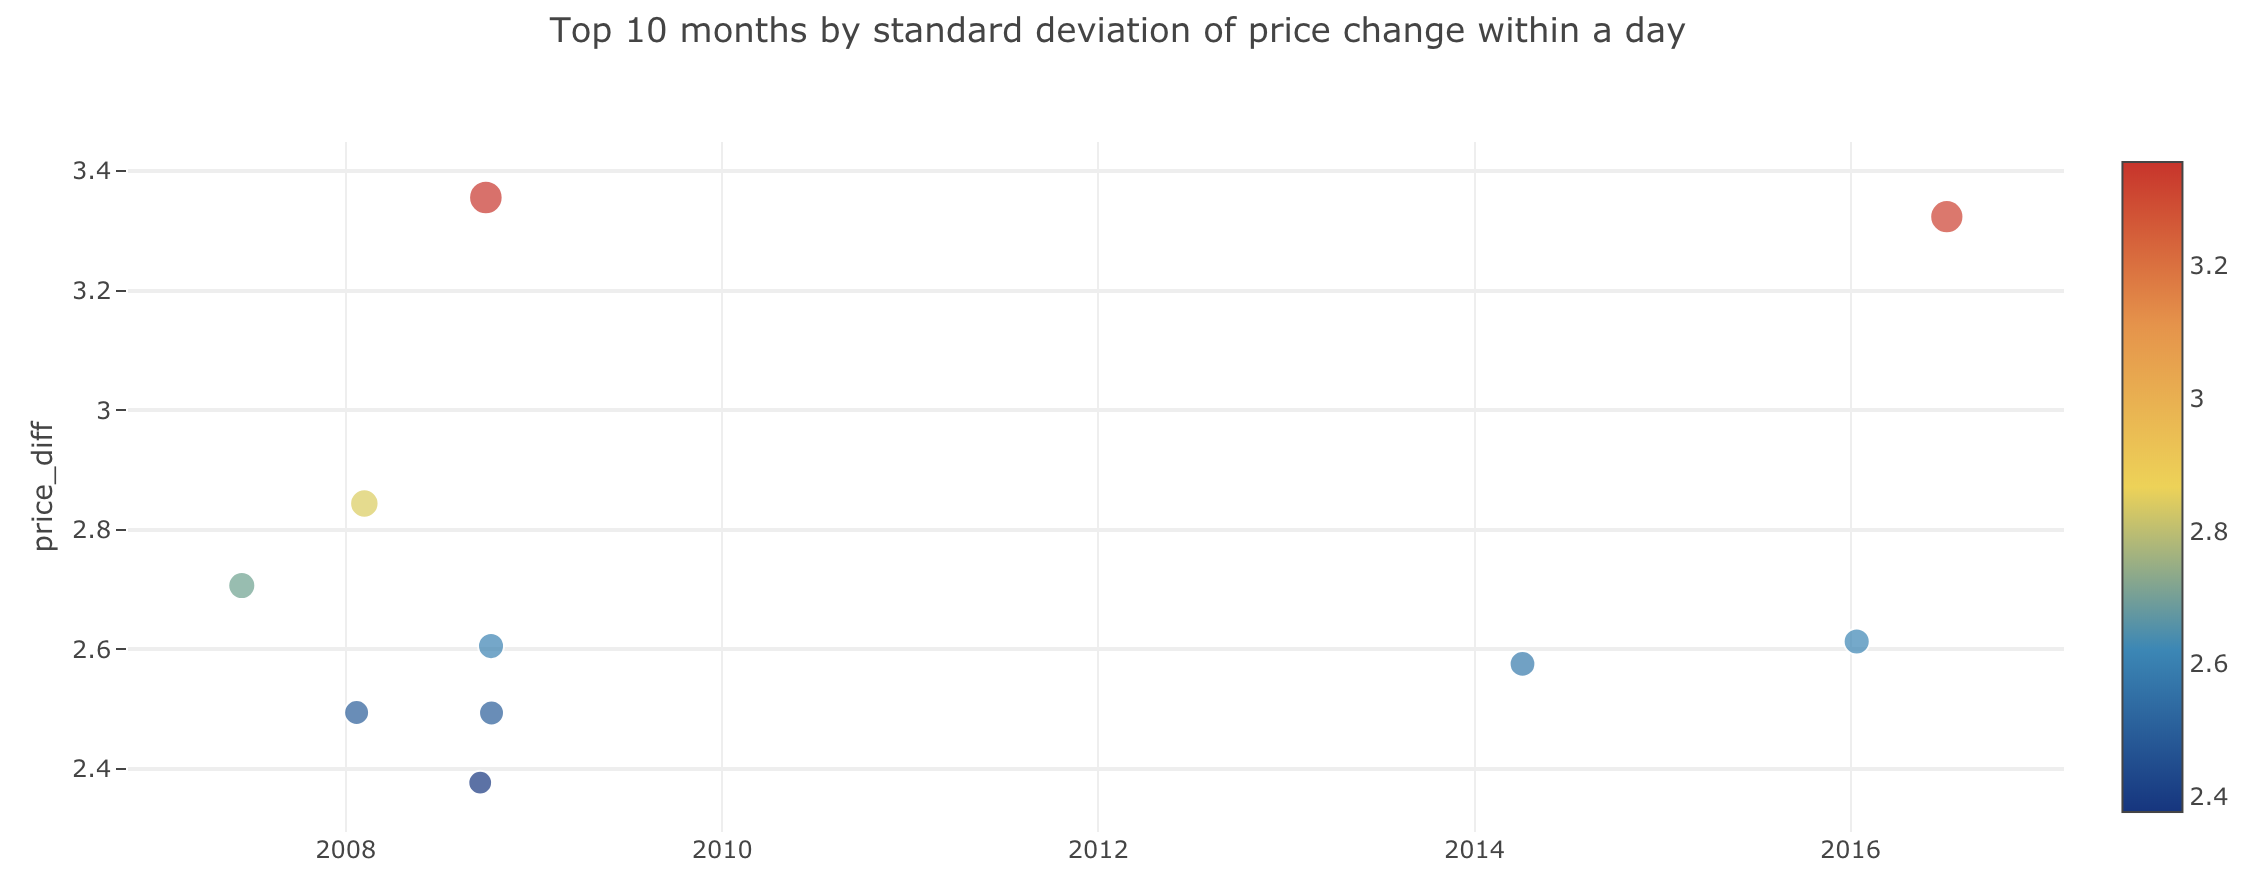

In [23]:
Image(filename='Images/top10_months_mod.png')

Now looking into the target variable.

In [ ]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

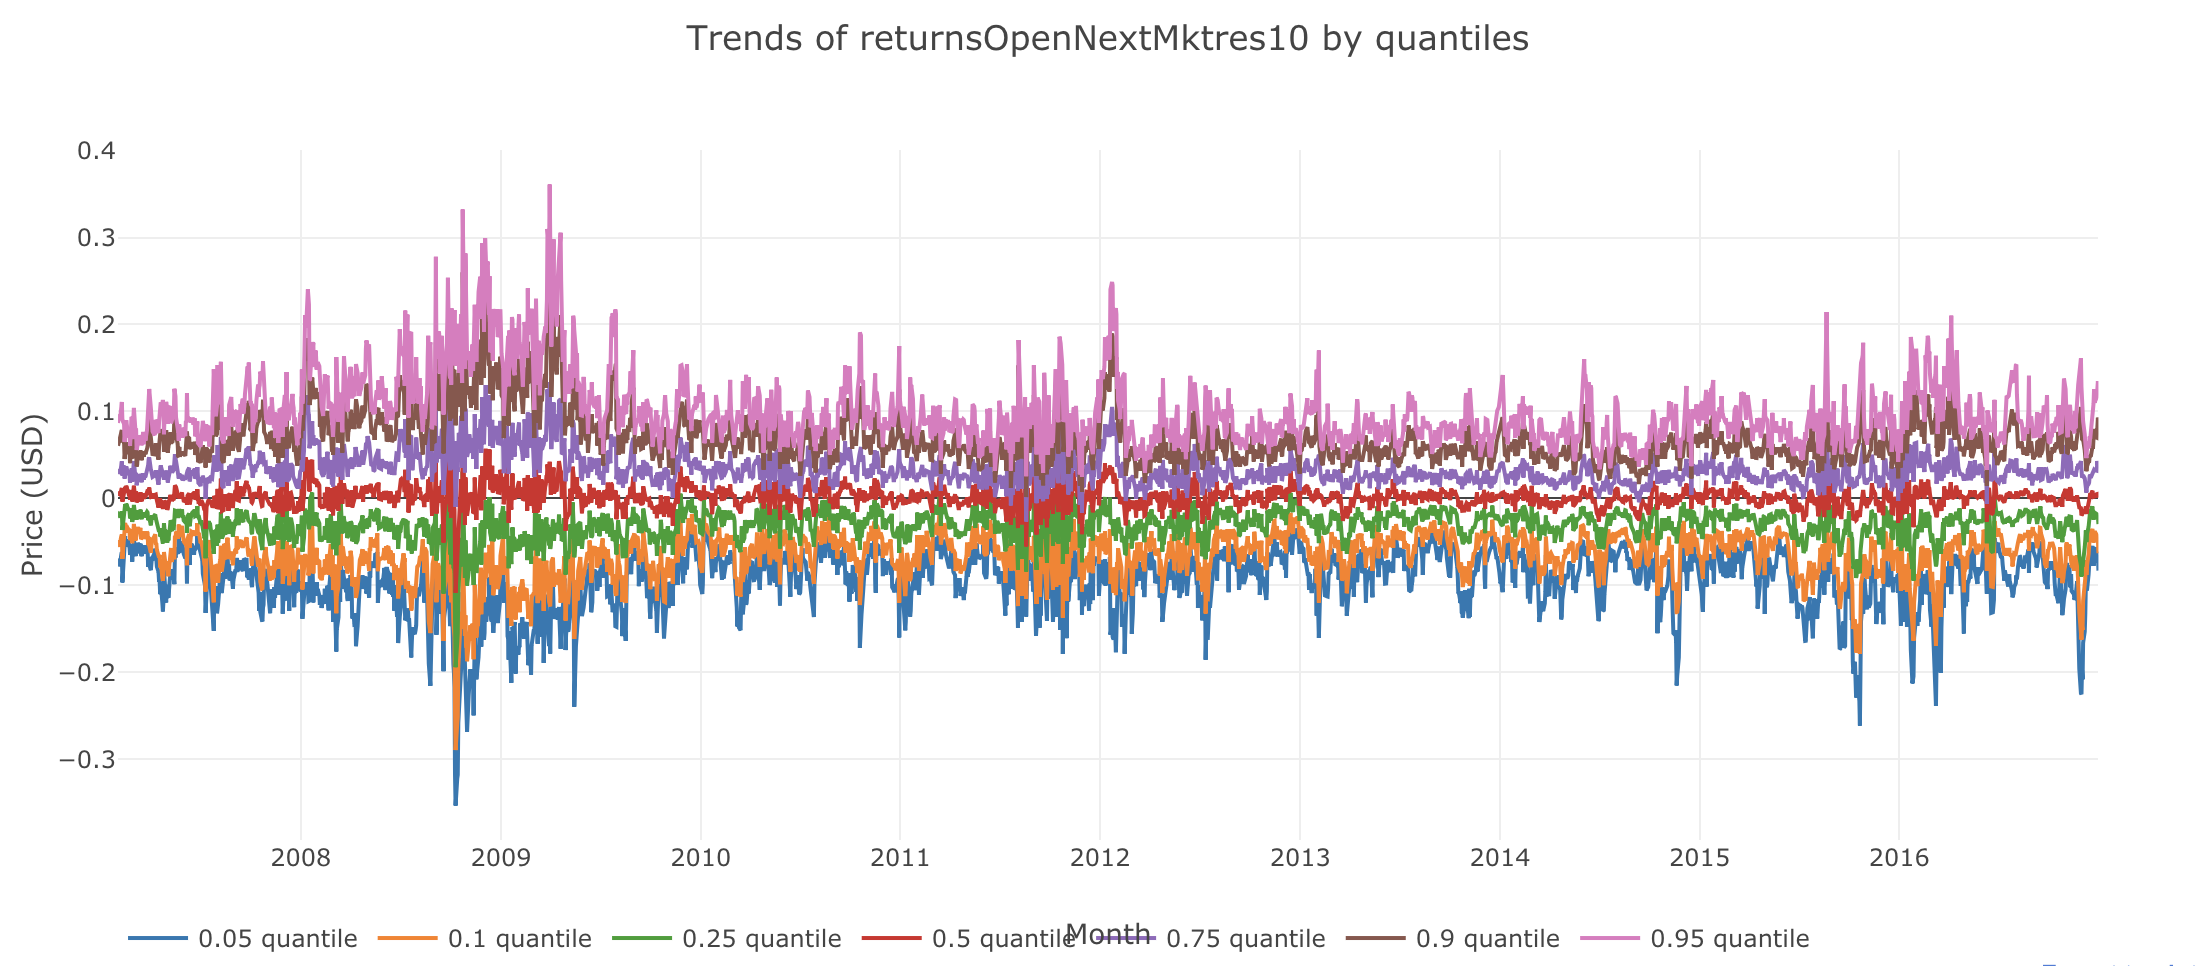

In [24]:
Image(filename='Images/trends_rtn.png')

There is a high deviation, but mean value remains stable.
Now looking only into data since 2010 year, to remove the impact of the crisis.

In [ ]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Trend of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

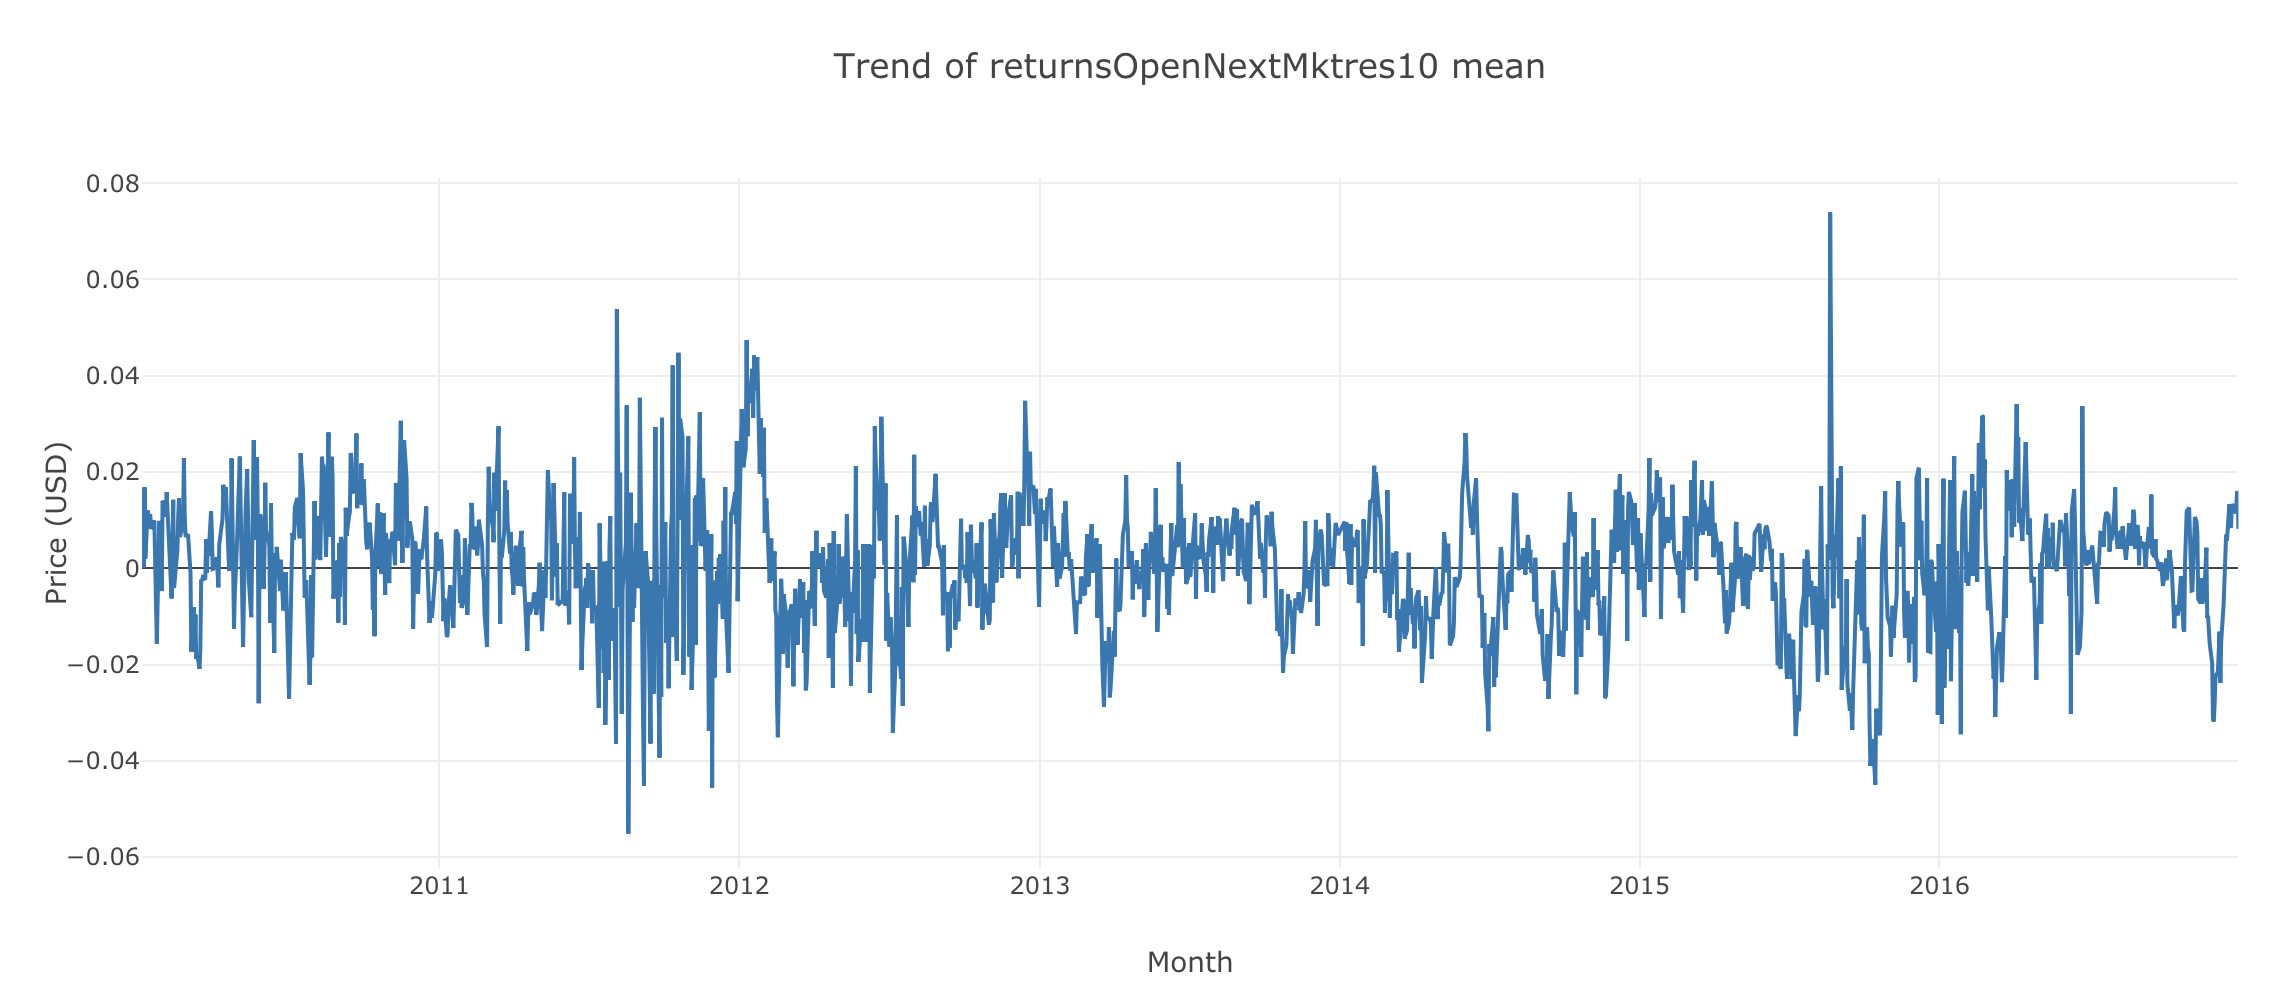

In [25]:
Image(filename='Images/trend_rtn_mean.png')

Now looking just at the means.

In [ ]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = market_train_df.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Treand of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

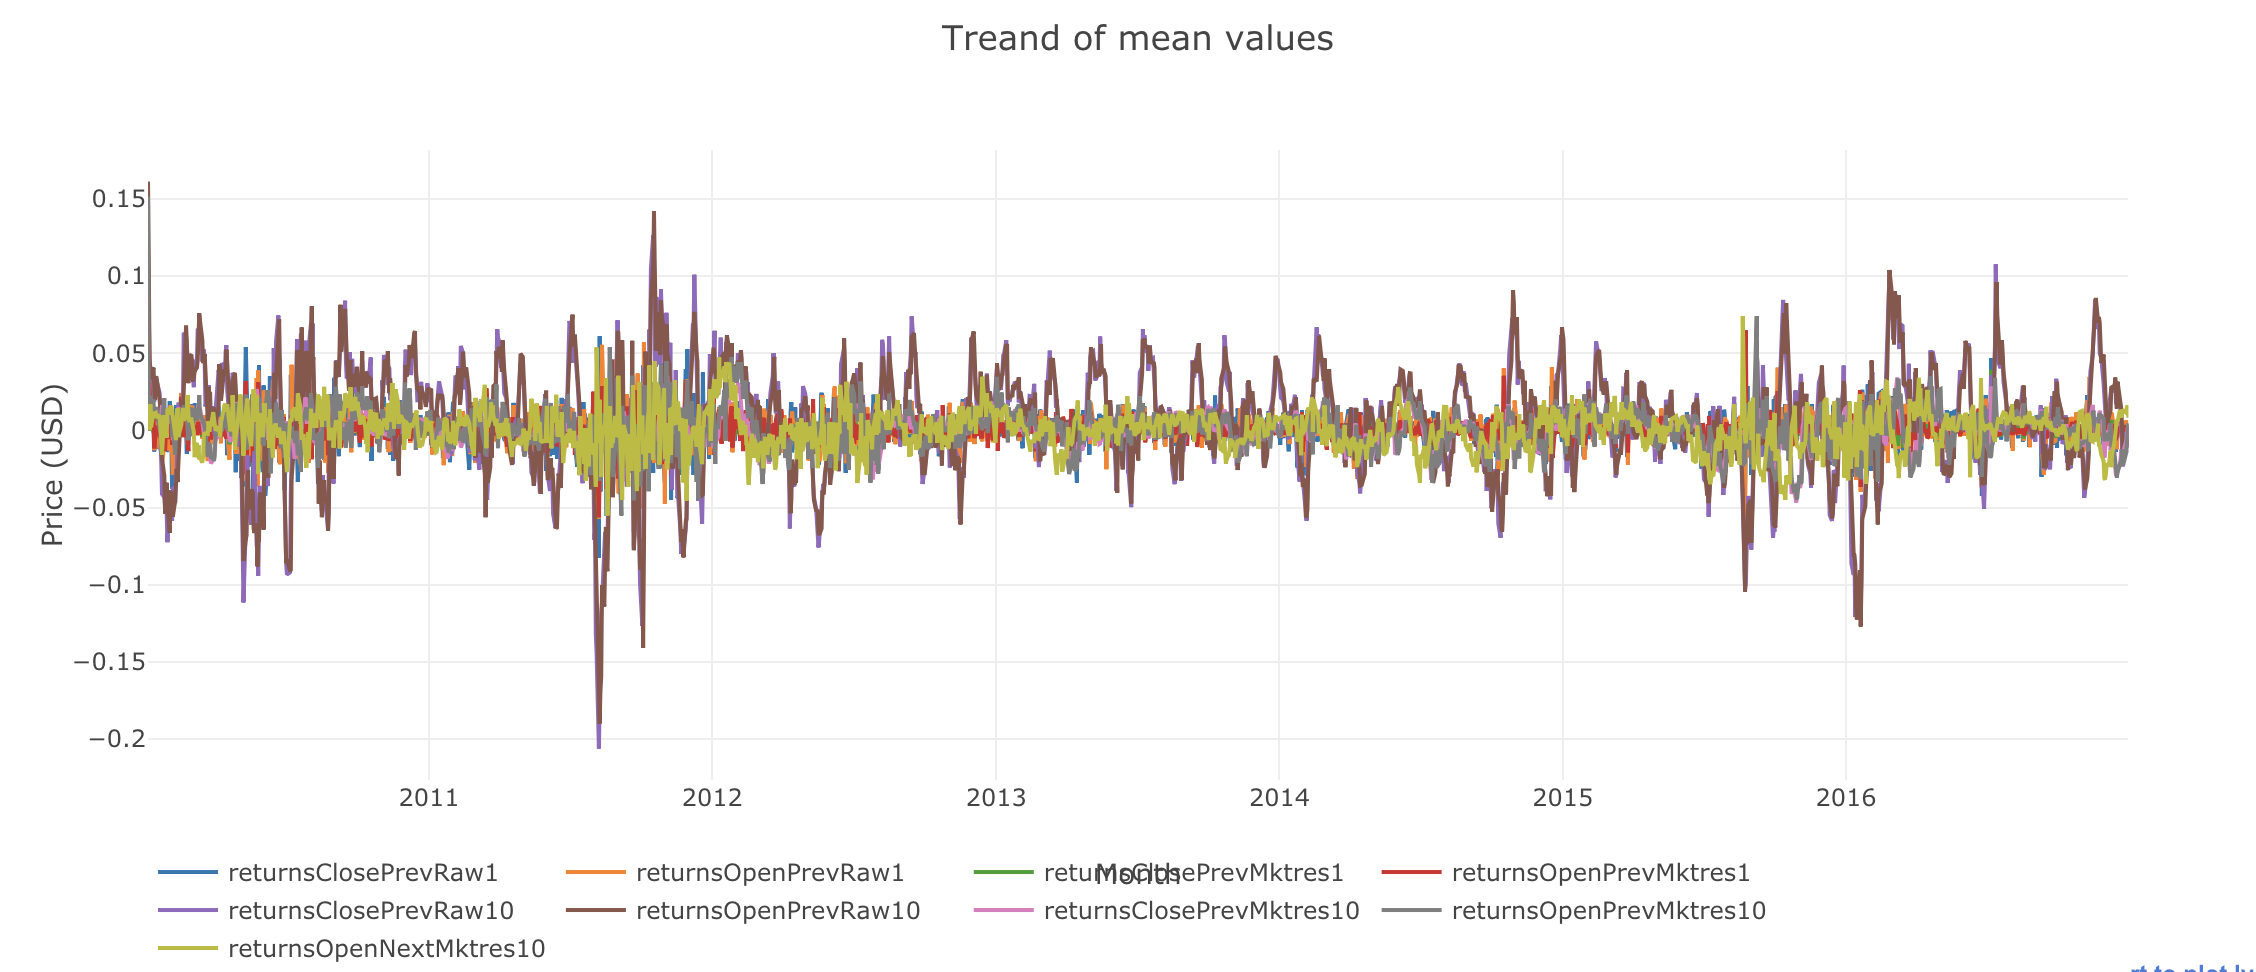

In [26]:
Image(filename='Images/trend_mean.png')

# News Data

In [ ]:
print(f'{news_train_df.shape[0]} samples and {news_train_df.shape[1]} features in the training news dataset.')

9328750 samples and 35 features in the training news dataset.

In [ ]:
text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

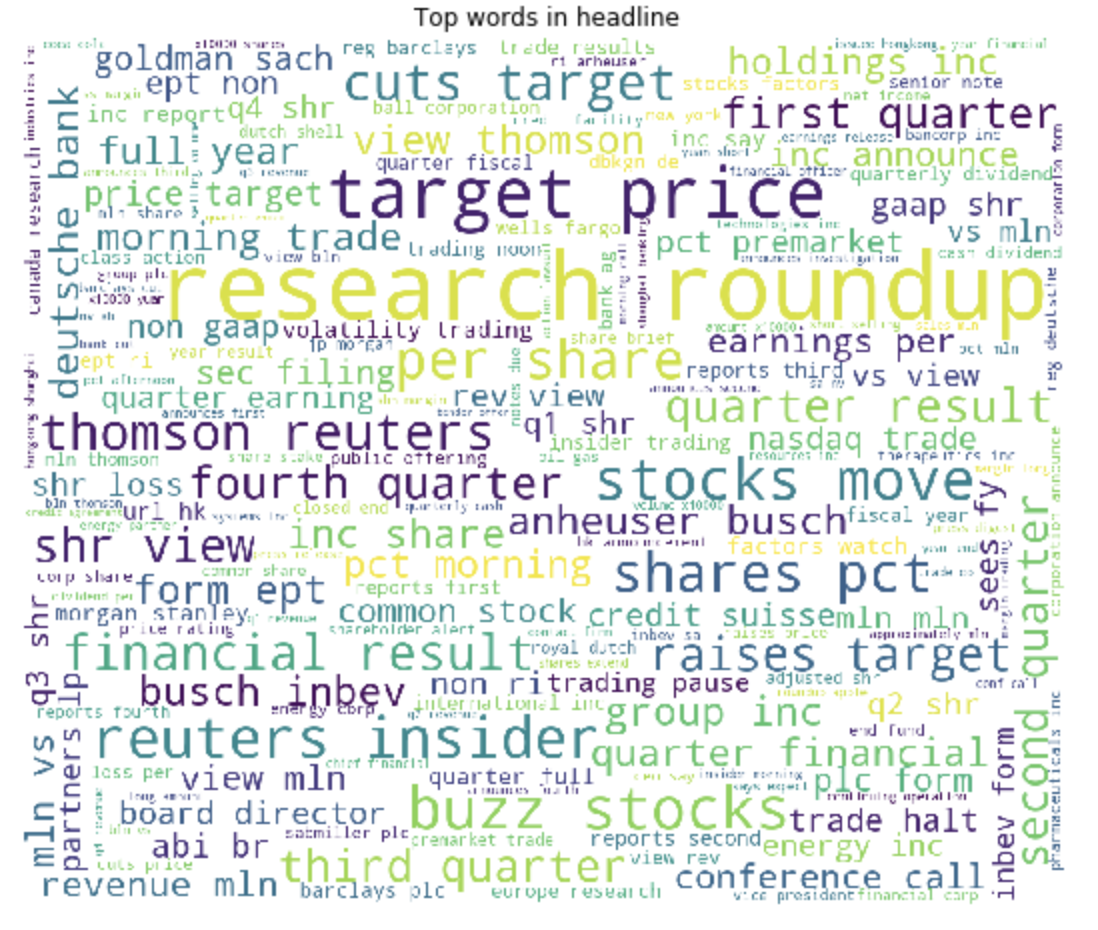

In [27]:
Image(filename='Images/word_cloud.png')

In [ ]:
news_train_df = news_train_df.loc[news_train_df['time'] >= '2010-01-01 22:00:00+0000']

plt.xticks(rotation=30);
plt.title('Urgency counts (mln)');

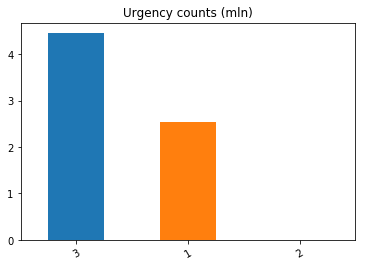

In [28]:
Image(filename='Images/urgency_count.png')

In [ ]:
news_train_df['sentence_word_count'] =  news_train_df['wordCount'] / news_train_df['sentenceCount']
plt.boxplot(news_train_df['sentence_word_count'][news_train_df['sentence_word_count'] < 40]);


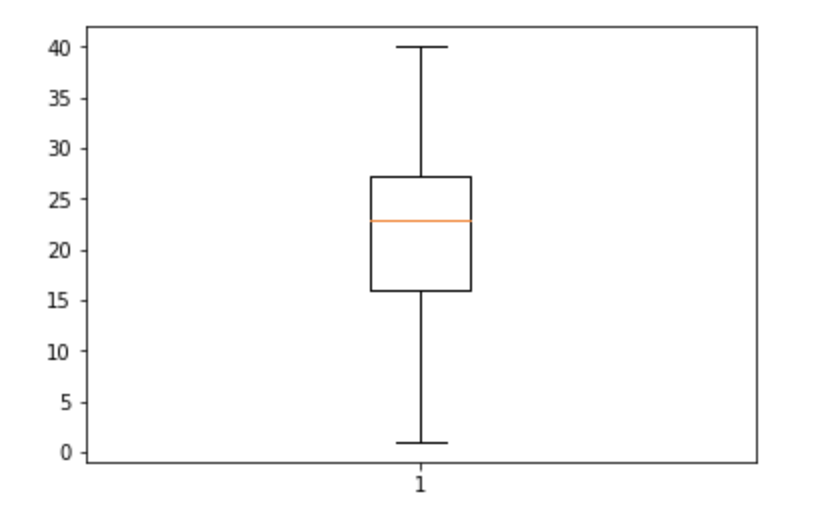

In [29]:
Image(filename='Images/sentence_word_count.png')

There are some big outliers, but sentences mostly have 15-25 words in them.

In [ ]:
news_train_df['provider'].value_counts().head(10)

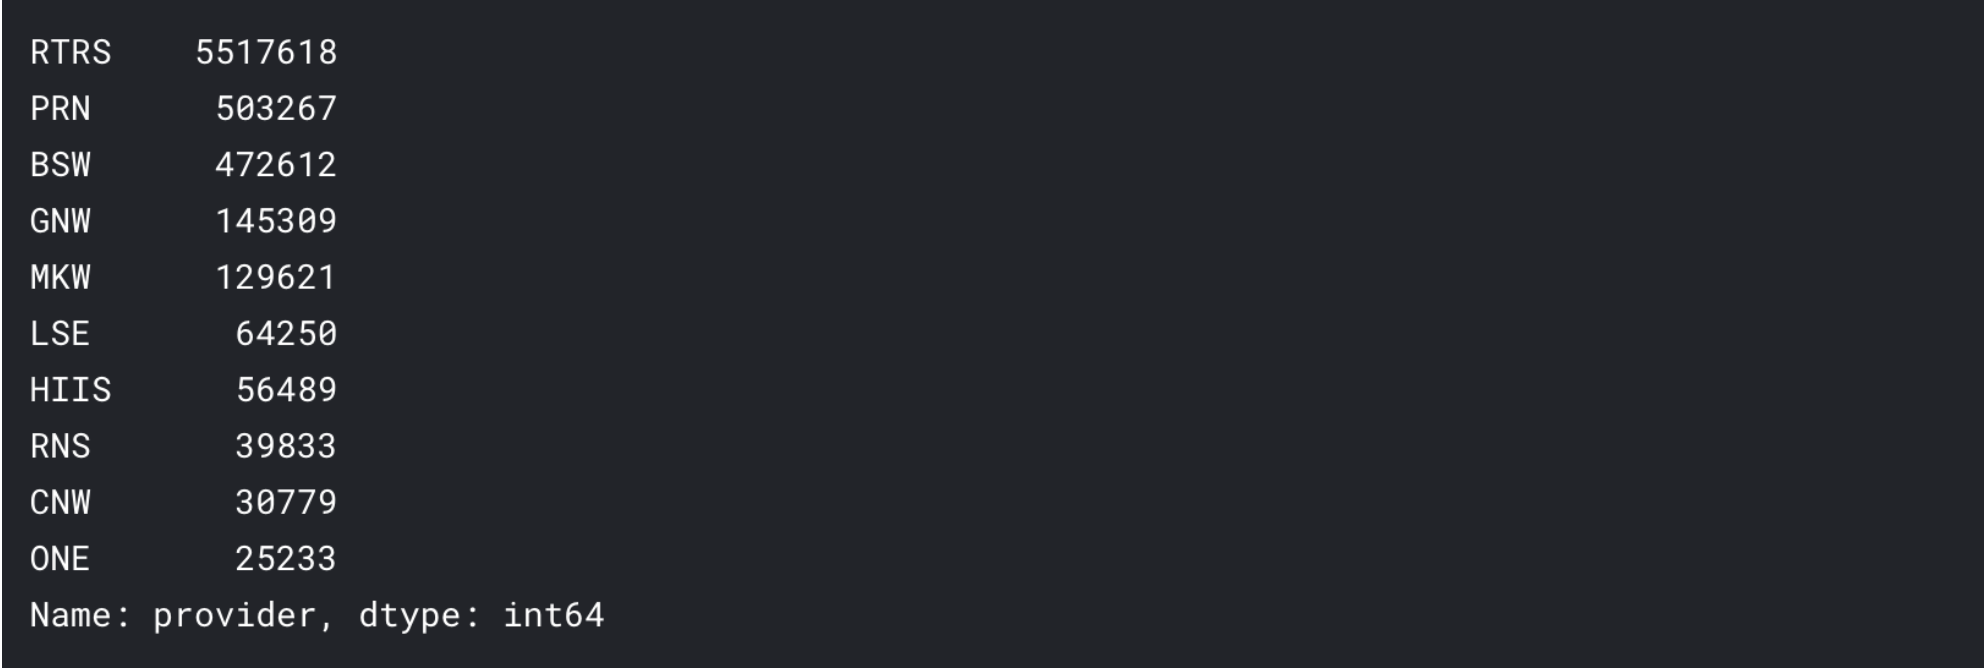

In [30]:
Image(filename='Images/provider.png')

Reuters is clearly, the major news provider in these dataset.

In [ ]:
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot('barh');
plt.title('headlineTag counts (thousands)');

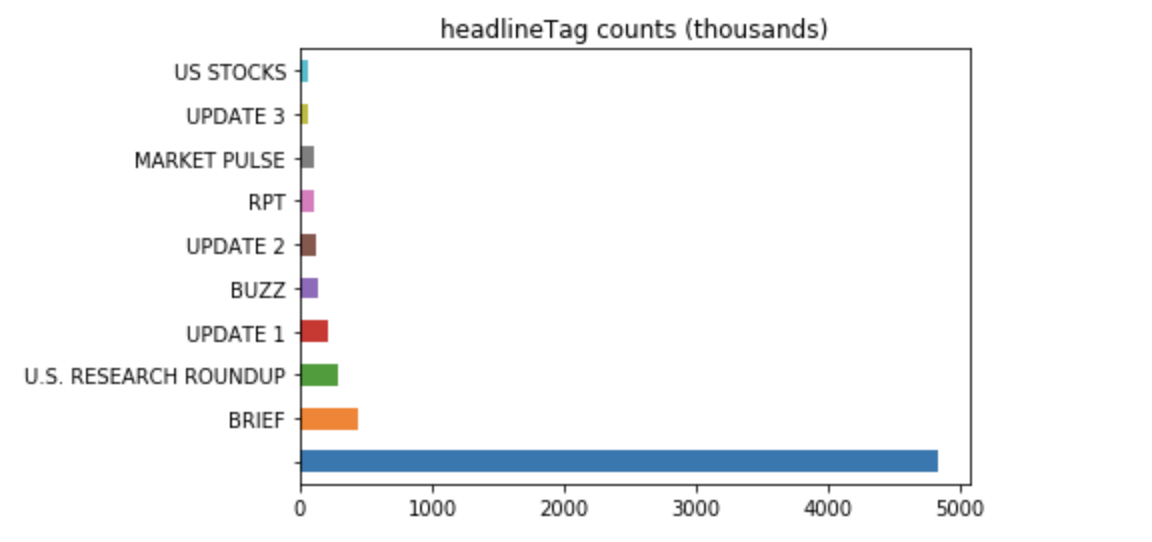

In [31]:
Image(filename='Images/headlinetag_counts.png')

Looking into the news summary.

In [ ]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Apple Inc                  22518
JPMorgan Chase & Co        20647
BP PLC                     19328
Goldman Sachs Group Inc    17955
Bank of America Corp       17704
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
HSBC Holdings PLC    19462
Credit Suisse AG     14632
Deutsche Bank AG     12959
Barclays PLC         12414
Apple Inc            10994
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Apple Inc                19020
Barclays PLC             18051
Royal Dutch Shell PLC    15484
General Electric Co      14163
Boeing Co                14080
Name: assetName, dtype: int64
